1. Take and visualize some content surveys (some with “ground truth” some without)
2. Run all of the standard measures of correlation and agreement for all responses (and visualize those with many and with few responses)
3. Use Bayesian multilevel models to get at different people’s slopes (each respondent is clustered)
	3. Consider downweighting people as a function of their sensitivity / lack of sensitivity
4. Use Bayesian annotation models (e.g., from PyAnno) to identify coder accuracy
5. Use Bayesian annotation models (e.g., from PyAnno) to produce MAP estimates

# Week 5 - Reliability

intro...

For this notebook we will be using the following packages

In [16]:
#All these packages need to be installed from pip
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn as sns #Makes the graphics look nicer

import pyanno #Uses pyanno3

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

Lets start by loading our data from the csv `data/reliabilty_data.csv`

In [2]:
dataDF = pandas.read_csv('data/reliabilty_data.csv')
dataDF[:5]

,survey_num,block_num,question_num,articleId,term,termInSentence,sentenceText,sampleEnt_category,sampleEnt_global,weight,item_hash,worker_anon,rating,rejected
0,0,1,1,2152,ball,"The <b class=""featured_term"">ball</b> did not ...",The ball did not scare the hole.,2.337821,2.618996,523.106061,-1068074272665598051,21,1.0,0
1,0,1,2,66815,time,Mone Davis was on the mound for the first <b c...,Mone Davis was on the mound for the first time...,1.751061,0.931097,567.560606,260332258467324137,21,6.0,0
2,0,1,3,2102,clear,"What is <b class=""featured_term"">clear</b> is ...",What is clear is that Libya is being torn apar...,0.001139,0.342433,2494.878788,4131272845504973345,21,7.0,0
3,0,1,4,1032,week,"He reviewed damage from the air on Saturday, a...","He reviewed damage from the air on Saturday, a...",2.041589,2.783811,523.106061,-6085910190079074856,21,7.0,0
4,0,1,5,14551,night,The mass on the right side of his chest was di...,The mass on the right side of his chest was di...,0.223507,1.352171,840.106061,6406557851487659544,21,7.0,0


In [5]:
#Code for this, probably jsut want to get rid of it
import nltk.metrics.agreement

def loadToAnnotation(fName):
    arr = np.loadtxt(fname=fName, dtype=int, delimiter=",")
    codes = []
    for taskNum, row in enumerate(arr):
        for codeNum, code in enumerate(row):
            codes.append(("c{}".format(codeNum), taskNum, code))
    return nltk.metrics.agreement.AnnotationTask(data = codes)

Load Rzhetsky et al (2009)'s sample dataset, which can be found [here](https://github.com/enthought/uchicago-pyanno/tree/master/data).

In [6]:
from pyanno.annotations import AnnotationsContainer
x = np.loadtxt("data/testdata_numerical.txt")
anno = AnnotationsContainer.from_array(x, missing_values=[-1])

Interrogate the AnnotationsContainer object.

In [7]:
anno.annotations

array([[ 1,  2,  3, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       [ 2,  2,  1, ..., -1, -1, -1],
       ..., 
       [ 2,  2, -1, ..., -1, -1,  1],
       [ 2,  2, -1, ..., -1, -1,  3],
       [ 1,  1, -1, ..., -1, -1,  0]])

In [8]:
anno.labels

[1.0, 2.0, 3.0, 4.0]

In [9]:
anno.missing_values

[-1]

# Annotation Statistics

Compute Cohen's kappa statistics, which measures the extent of agreement between two annotators. Here, Cohen's kappa statistics for the first two annotators are computed.

In [10]:
from pyanno.measures import cohens_kappa, pairwise_matrix
cohens_kappa(anno.annotations[:,0], anno.annotations[:,1])

0.43917037219392857

Get the pairwise measure matrix.

In [11]:
m = pairwise_matrix(cohens_kappa, anno.annotations)
print (m)

[[ 1.          0.43917037  0.47677621         nan         nan         nan
   0.45819119  0.43381462]
 [ 0.43917037  1.          0.38432922  0.41344423         nan         nan
          nan  0.33643611]
 [ 0.47677621  0.38432922  1.          0.39583333  0.51704894         nan
          nan         nan]
 [        nan  0.41344423  0.39583333  1.          0.34597068  0.4446844
          nan         nan]
 [        nan         nan  0.51704894  0.34597068  1.          0.37938644
   0.43039733         nan]
 [        nan         nan         nan  0.4446844   0.37938644  1.
   0.38341929  0.31214748]
 [ 0.45819119         nan         nan         nan  0.43039733  0.38341929
   1.          0.394806  ]
 [ 0.43381462  0.33643611         nan         nan         nan  0.31214748
   0.394806    1.        ]]


A heatmap visualization:

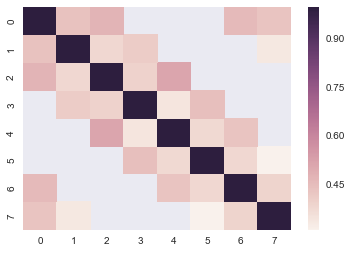

In [15]:
ax = sns.heatmap(m)
plt.show()

# Models

Now we use Rzhetsky et al (2009)'s models to make inference about true label classes. Pyanno provides four available models: ModelA, ModelB, ModelBt, and ModelBtLoopDesign. They should give similar results. To estimate the parameters for any models, we first need to create a new model. 

In [13]:
from pyanno.models import ModelA
# create a new instance of model A, with 4 label classes
model = ModelA.create_initial_state(4)
# other model parameters are initialized from the model prior
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.67656777  0.64359294  0.80628952  0.78992598  0.65420135  0.8527734
  0.77422835  0.61537893]
-3916.77463633


Pyanno allows one to use either MLE (maximum likelihood estimation) or MAP (maximum a posteriori estimation) to estimate model parameters. The estimates should not differ a lot. Note that the parameters here are the accuracy of each annotator.

In [17]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79537198  0.7333457   0.76943907  0.71016615  0.72286427  0.71940173
  0.75779457  0.71251885]
-2817.51941234


In [19]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79461331  0.73218931  0.76849069  0.70897619  0.72177671  0.71811446
  0.75680804  0.71114671]
-2817.51365112


After we have model parameters estimated, we can make inference about the true label classes. We can calculate the posterior distribution over the true label classes.

In [20]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[ 0.02767565  0.37912394  0.26791259  0.32528782]
 [ 0.99572448  0.00142517  0.00142517  0.00142517]
 [ 0.00930733  0.10333509  0.87805024  0.00930733]
 ..., 
 [ 0.0095626   0.07874271  0.90213209  0.0095626 ]
 [ 0.0095626   0.0095626   0.90213209  0.07874271]
 [ 0.07874271  0.90213209  0.0095626   0.0095626 ]]


sample_posterior_over_accuracy() allows drawing samples from the posterior of the accuracy parameters. We can use such samples to draw credible intervals.

In [21]:
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
print(samples.mean(axis=0))
print(samples.std(axis=0))

[ 0.79283761  0.7326012   0.78092213  0.70103041  0.72095367  0.71969414
  0.75914744  0.70489113]
[ 0.028033    0.02756623  0.02821893  0.03530565  0.03114093  0.02976061
  0.0334906   0.03327899]


Let's try everything again with ModelBt

In [22]:
from pyanno.models import ModelBt
# create a new instance of model B, with 4 label classes and 8 annotators.
model = ModelBt.create_initial_state(4, 8)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.86028378  0.70878892  0.73763084  0.64519056  0.93148672  0.90330634
  0.91606124  0.92971742]
-3058.18194501


In [23]:
model.map(anno.annotations)
print(model.theta)
print(model.log_likelihood(anno.annotations))

[ 0.79135144  0.74074084  0.76229281  0.72523642  0.71642462  0.71859284
  0.7731781   0.71665037]
-2811.94633178


In [24]:
posterior = model.infer_labels(anno.annotations)
print(posterior)

[[ 0.01110547  0.28937453  0.36489943  0.33462056]
 [ 0.99023206  0.00241688  0.00404567  0.00330539]
 [ 0.00249984  0.0550758   0.93459499  0.00782937]
 ..., 
 [ 0.00252928  0.04394911  0.94560006  0.00792156]
 [ 0.00249429  0.00571208  0.93251923  0.0592744 ]
 [ 0.03189442  0.93882693  0.01611356  0.01316508]]


# Generating Annotations

Pyanno also allows one to generate artificial data from a model.

In [25]:
model = ModelBt.create_initial_state(4, 3, theta=[0.99,0.75,0.25])
#randome generate annotations with 4 label classes and 3 annotators. The accuracy of the three annotators are 0.99, 0.75, and 0.25 respectively.
model.generate_annotations(20)

array([[2, 2, 2],
       [0, 0, 2],
       [3, 3, 3],
       [1, 3, 3],
       [3, 3, 2],
       [0, 0, 1],
       [2, 2, 0],
       [3, 1, 3],
       [2, 2, 2],
       [0, 0, 0],
       [2, 0, 3],
       [1, 1, 0],
       [3, 3, 2],
       [0, 0, 2],
       [2, 2, 0],
       [3, 0, 2],
       [0, 1, 3],
       [2, 2, 0],
       [1, 1, 0],
       [3, 3, 0]])

# Visualization

Pyanno provides a [graphical user interface](http://docs.enthought.com/uchicago-pyanno/user_guide.html) for making plots. However, it is not compatible with ipyton notebook. Nevertheless, nothing prevents us from making plots using matplotlib. Let's make a plot of the accuracy of each annotator inferred from ModelA.

In [26]:
model = ModelA.create_initial_state(4)
model.mle(anno.annotations)
samples = model.sample_posterior_over_accuracy(anno.annotations, 200, burn_in_samples=100, thin_samples=3)
y =  samples.mean(axis=0)
y_ci = samples.std(axis=0)

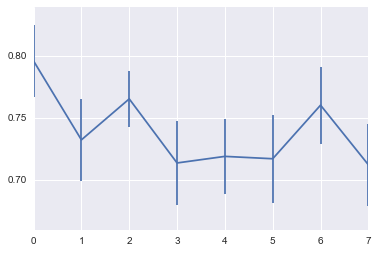

In [27]:
plt.figure()
plt.errorbar(range(8),y, yerr = y_ci)
plt.show()